This notebook is used to model the frequency response we *should* expect to get from the species that were inside AZKABAN

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
from scipy import stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

import inverse_method_funs_med as inv

In [5]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}


plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['font.size']= 15

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16

# Read results from scattering models
Scattering models for the copepods, krill and chaetognaths in the nets were run in ZooScatR, a package that runs PC-DWBA.

In [6]:
fname_sim = '../ZooScatStuff/AZKABAN_ZoopMix_data_TenThousand.feather'
simulations = pd.read_feather(fname_sim)
# Add a row for sigma_bs calculated from TS
simulations['sigbs'] = 10**(simulations.TS/10)

In [7]:
specs = simulations.spec.unique()
freqs = simulations.freq.unique()

# Calculate ci

In [8]:
def ci0(x):
    return  st.t.interval(0.50, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[0]
def ci1(x):
    return  st.t.interval(0.50, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[1]

ci_0 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0})
ci_1 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1})

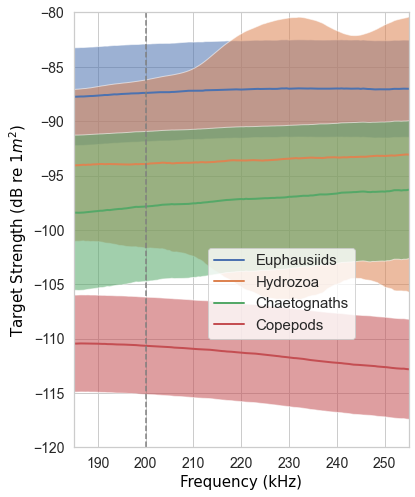

In [9]:
# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(figsize=(6, 8),facecolor='w', edgecolor='k')
order = [1,3,2,0]
label_name=['Copepods', 'Euphausiids', 'Chaetognaths', 'Hydrozoa']
for ind in order:

    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[ind]]['sigbs'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))
    
    plt.plot(freqs,10*np.log10(median_select), linewidth=2, label=label_name[ind])
    plt.fill_between(freqs,logci_0, logci_1, alpha=0.55)
    
plt.legend(fontsize=15, loc=(0.40,0.25))
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.axvline(x=200, linestyle='--', c='grey')
plt.xlim([185,255])
plt.ylim([-120,-80])
#plt.title('Scattering model results', title_font);

ax.set_rasterized(True)
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/AZKABAN_modeledspectra.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
#fig.savefig(savefigjpg_path+'Figure6.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [81]:
# Print mean TS
for spec_ind in range(len(specs)):
    TS_mean = 10*np.log10(np.mean(median_bs[median_bs.index==specs[spec_ind]].sigbs))
    print(f'Mean TS for {specs[spec_ind]} is {TS_mean:.2f} dB re 1m^2.')

Mean TS for Copepods is -112.22 dB re 2m^2.
Mean TS for Euphausiids is -87.33 dB re 2m^2.
Mean TS for Chaetognaths is -95.77 dB re 2m^2.
Mean TS for Jellyfish is -92.66 dB re 2m^2.


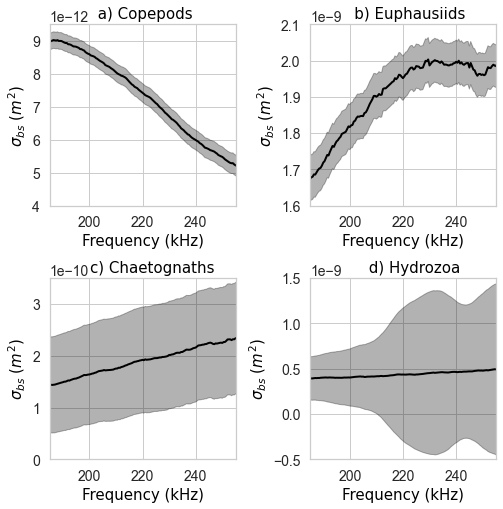

In [86]:
def ci0_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[1]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})

# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(2,2, figsize=(8, 8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=0.4)
axes = ax.flatten()
order = [0,1,2,3]
letter = [' a) Copepods','   b) Euphausiids', '    c) Chaetognaths', '     d) Hydrozoa']
for i in range(4):
    ind = order[i]
    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0_linear.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1_linear.loc[specs[ind]]['sigbs'].to_numpy()

    
    axes[i].plot(freqs,median_select, color='black', linewidth=2)#, color=sns.color_palette()[i])
    axes[i].fill_between(freqs,ci_0_select, ci_1_select, color='black', alpha=0.3)#, color=sns.color_palette()[i])
    
    axes[i].set_title(letter[i], title_font)
    axes[i].set_ylabel('$\sigma_{bs}$ ($m^{2}$)', axis_font)
    axes[i].set_xlabel('Frequency (kHz)', axis_font)
    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[i].set_xlim([185,255])
    axes[i].set_rasterized(True)
    
axes[0].set_ylim([4e-12,9.5e-12])
axes[1].set_ylim([1.6e-9,2.1e-9])    
axes[2].set_ylim([0,3.5e-10])
axes[3].set_ylim([-0.5e-9,1.5e-9])


#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figure5.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

# Plot length distributions

In [13]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# For gamma distirbution scale = 1/rate. alpha = shape.
# For log normal distribution. s=sigma(logstd), scale=e^(mu or logmean)

# Length distribution was calculated using all measured lengths (divided by 2!)
x=np.arange(0,35,0.01)
euphausiid_dist = stats.lognorm.pdf(x, s=0.3,scale=np.exp(2.4))
jelly_dist = stats.lognorm.pdf(x, s=0.4, scale=np.exp(2.4))
chaetognaths_dist = stats.gamma.pdf(x, a=10.6, scale=1/0.6)
copepod_dist = stats.norm.pdf(x, loc=3.3, scale = 0.7)

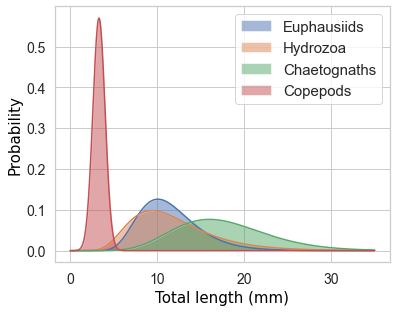

In [14]:
plt.figure(figsize=(6,16))
ax = plt.subplot(3,1,1)
plt.plot(x, euphausiid_dist)
plt.fill_between(x, euphausiid_dist, alpha=0.5, label='Euphausiids')
plt.plot(x, jelly_dist)
plt.fill_between(x, jelly_dist, alpha=0.5, label='Hydrozoa')
plt.plot(x, chaetognaths_dist)
plt.fill_between(x, chaetognaths_dist, alpha=0.5, label='Chaetognaths')
plt.plot(x, copepod_dist)
plt.fill_between(x, copepod_dist, alpha=0.5, label='Copepods')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=15)


In [77]:
Euphausiid_mean = stats.lognorm.median(s=0.3,scale=np.exp(2.4))
Euphausiid_std = stats.lognorm.std(s=0.3,scale=np.exp(2.4))
print(f'Mean length of euphausiids is {Euphausiid_mean: .2f} $\pm {Euphausiid_std: .2f} mm')

Mean length of euphausiids is  11.02 $\pm  3.54


In [79]:
Jelly_mean = stats.lognorm.median(s=0.4,scale=np.exp(2.4))
Jelly_std = stats.lognorm.std(s=0.4,scale=np.exp(2.4))
print(f' Mean length of hydrozoa is {Jelly_mean: .2f} \pm {Jelly_std: .2f} mm')

 Mean length of hydrozoa is  11.02 \pm  4.97 mm


In [80]:
Chaeto_mean = stats.gamma.median(a=10.6, scale=1/0.6)
Chaeto_std= stats.gamma.std(a=10.6, scale=1/0.6)
print(f'Mean length of chaetognaths {Chaeto_mean: .2f} \pm {Chaeto_std: .2f} mm')

Mean length of chaetognaths  17.11 \pm  5.43 mm


In [ ]:
sns.histplot(data=simulations, x='L', hue='spec', stat='density')